<a href="https://colab.research.google.com/github/prakash-bisht/Pytorch_Basic/blob/master/pytorch7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#multi-gpu & multi-machine

In [ ]:
%%writefile datautils.py
import torch
from torch.utils.data import Dataset

class MyTrainDataset(Dataset):
    def __init__(self, size):
        self.size = size
        self.data = [(torch.rand(20), torch.rand(1)) for _ in range(size)]

    def __len__(self):
        return self.size
    
    def __getitem__(self, index):
        return self.data[index]

Writing datautils.py


In [ ]:
import torch
from torch.utils.data import Dataset

class MyTrainDataset(Dataset):
    def __init__(self, size):
        self.size = size
        self.data = [(torch.rand(20), torch.rand(1)) for _ in range(size)]

    def __len__(self):
        return self.size
    
    def __getitem__(self, index):
        return self.data[index]

In [ ]:
%%writefile single_gpu.py
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datautils import MyTrainDataset


class Trainer:
    def __init__(
        self,
        model: torch.nn.Module,
        train_data: DataLoader,
        optimizer: torch.optim.Optimizer,
        gpu_id: int,
        save_every: int, 
    ) -> None:
        self.gpu_id = gpu_id
        self.model = model.to(gpu_id)
        self.train_data = train_data
        self.optimizer = optimizer
        self.save_every = save_every

    def _run_batch(self, source, targets):
        self.optimizer.zero_grad()
        output = self.model(source)
        loss = F.cross_entropy(output, targets)
        loss.backward()
        self.optimizer.step()

    def _run_epoch(self, epoch):
        b_sz = len(next(iter(self.train_data))[0])
        print(f"[GPU{self.gpu_id}] Epoch {epoch} | Batchsize: {b_sz} | Steps: {len(self.train_data)}")
        for source, targets in self.train_data:
            source = source.to(self.gpu_id)
            targets = targets.to(self.gpu_id)
            self._run_batch(source, targets)

    def _save_checkpoint(self, epoch):
        ckp = self.model.state_dict()
        PATH = "checkpoint.pt"
        torch.save(ckp, PATH)
        print(f"Epoch {epoch} | Training checkpoint saved at {PATH}")

    def train(self, max_epochs: int):
        for epoch in range(max_epochs):
            self._run_epoch(epoch)
            if epoch % self.save_every == 0:
                self._save_checkpoint(epoch)


def load_train_objs():
    train_set = MyTrainDataset(2048)  # load your dataset
    model = torch.nn.Linear(20, 1)  # load your model
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    return train_set, model, optimizer


def prepare_dataloader(dataset: Dataset, batch_size: int):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=True
    )


def main(device, total_epochs, save_every, batch_size):
    dataset, model, optimizer = load_train_objs()
    train_data = prepare_dataloader(dataset, batch_size)
    trainer = Trainer(model, train_data, optimizer, device, save_every)
    trainer.train(total_epochs)


if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser(description='simple distributed training job')
    parser.add_argument('total_epochs', type=int, help='Total epochs to train the model')
    parser.add_argument('save_every', type=int, help='How often to save a snapshot')
    parser.add_argument('--batch_size', default=32, type=int, help='Input batch size on each device (default: 32)')
    args = parser.parse_args()
    
    device = 0  # shorthand for cuda:0
    main(device, args.total_epochs, args.save_every, args.batch_size)

Overwriting single_gpu.py


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datautils import MyTrainDataset


class Trainer:
    def __init__(
        self,
        model: torch.nn.Module,
        train_data: DataLoader,
        optimizer: torch.optim.Optimizer,
        gpu_id: int,
        save_every: int, 
    ) -> None:
        self.gpu_id = gpu_id
        self.model = model.to(gpu_id)
        self.train_data = train_data
        self.optimizer = optimizer
        self.save_every = save_every

    def _run_batch(self, source, targets):
        self.optimizer.zero_grad()
        output = self.model(source)
        loss = F.cross_entropy(output, targets)
        loss.backward()
        self.optimizer.step()

    def _run_epoch(self, epoch):
        b_sz = len(next(iter(self.train_data))[0])
        print(f"[GPU{self.gpu_id}] Epoch {epoch} | Batchsize: {b_sz} | Steps: {len(self.train_data)}")
        for source, targets in self.train_data:
            source = source.to(self.gpu_id)
            targets = targets.to(self.gpu_id)
            self._run_batch(source, targets)

    def _save_checkpoint(self, epoch):
        ckp = self.model.state_dict()
        PATH = "checkpoint.pt"
        torch.save(ckp, PATH)
        print(f"Epoch {epoch} | Training checkpoint saved at {PATH}")

    def train(self, max_epochs: int):
        for epoch in range(max_epochs):
            self._run_epoch(epoch)
            if epoch % self.save_every == 0:
                self._save_checkpoint(epoch)


def load_train_objs():
    train_set = MyTrainDataset(2048)  # load your dataset
    model = torch.nn.Linear(20, 1)  # load your model
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    return train_set, model, optimizer


def prepare_dataloader(dataset: Dataset, batch_size: int):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=True
    )


def main(device, total_epochs, save_every, batch_size):
    dataset, model, optimizer = load_train_objs()
    train_data = prepare_dataloader(dataset, batch_size)
    trainer = Trainer(model, train_data, optimizer, device, save_every)
    trainer.train(total_epochs)


if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser(description='simple distributed training job')
    parser.add_argument('total_epochs', type=int, help='Total epochs to train the model')
    parser.add_argument('save_every', type=int, help='How often to save a snapshot')
    parser.add_argument('--batch_size', default=32, type=int, help='Input batch size on each device (default: 32)')
    args = parser.parse_args()
    
    device = 0  # shorthand for cuda:0
    main(device, args.total_epochs, args.save_every, args.batch_size)

In [ ]:
!python single_gpu.py 20 10

[GPU0] Epoch 0 | Batchsize: 32 | Steps: 64
Epoch 0 | Training checkpoint saved at checkpoint.pt
[GPU0] Epoch 1 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 2 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 3 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 4 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 5 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 6 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 7 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 8 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 9 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 10 | Batchsize: 32 | Steps: 64
Epoch 10 | Training checkpoint saved at checkpoint.pt
[GPU0] Epoch 11 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 12 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 13 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 14 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 15 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 16 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 17 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 18 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 19 | Batchsize: 32 | Steps: 64


In [ ]:
%%writefile multi_gpu.py
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datautils import MyTrainDataset

import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os


def ddp_setup(rank, world_size):
    """
    Args:
        rank: Unique identifier of each process
        world_size: Total number of processes
    """
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12355"
    init_process_group(backend="nccl", rank=rank, world_size=world_size)

class Trainer:
    def __init__(
        self,
        model: torch.nn.Module,
        train_data: DataLoader,
        optimizer: torch.optim.Optimizer,
        gpu_id: int,
        save_every: int,
    ) -> None:
        self.gpu_id = gpu_id
        self.model = model.to(gpu_id)
        self.train_data = train_data
        self.optimizer = optimizer
        self.save_every = save_every
        self.model = DDP(model, device_ids=[gpu_id])

    def _run_batch(self, source, targets):
        self.optimizer.zero_grad()
        output = self.model(source)
        loss = F.cross_entropy(output, targets)
        loss.backward()
        self.optimizer.step()

    def _run_epoch(self, epoch):
        b_sz = len(next(iter(self.train_data))[0])
        print(f"[GPU{self.gpu_id}] Epoch {epoch} | Batchsize: {b_sz} | Steps: {len(self.train_data)}")
        self.train_data.sampler.set_epoch(epoch)
        for source, targets in self.train_data:
            source = source.to(self.gpu_id)
            targets = targets.to(self.gpu_id)
            self._run_batch(source, targets)

    def _save_checkpoint(self, epoch):
        ckp = self.model.module.state_dict()
        PATH = "checkpoint.pt"
        torch.save(ckp, PATH)
        print(f"Epoch {epoch} | Training checkpoint saved at {PATH}")

    def train(self, max_epochs: int):
        for epoch in range(max_epochs):
            self._run_epoch(epoch)
            if self.gpu_id == 0 and epoch % self.save_every == 0:
                self._save_checkpoint(epoch)


def load_train_objs():
    train_set = MyTrainDataset(2048)  # load your dataset
    model = torch.nn.Linear(20, 1)  # load your model
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    return train_set, model, optimizer


def prepare_dataloader(dataset: Dataset, batch_size: int):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        sampler=DistributedSampler(dataset)
    )


def main(rank: int, world_size: int, save_every: int, total_epochs: int, batch_size: int):
    ddp_setup(rank, world_size)
    dataset, model, optimizer = load_train_objs()
    train_data = prepare_dataloader(dataset, batch_size)
    trainer = Trainer(model, train_data, optimizer, rank, save_every)
    trainer.train(total_epochs)
    destroy_process_group()


if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser(description='simple distributed training job')
    parser.add_argument('total_epochs', type=int, help='Total epochs to train the model')
    parser.add_argument('save_every', type=int, help='How often to save a snapshot')
    parser.add_argument('--batch_size', default=32, type=int, help='Input batch size on each device (default: 32)')
    args = parser.parse_args()
    
    world_size = torch.cuda.device_count()
    mp.spawn(main, args=(world_size, args.save_every, args.total_epochs, args.batch_size), nprocs=world_size)

Writing multi_gpu.py


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datautils import MyTrainDataset

import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os


def ddp_setup(rank, world_size):
    """
    Args:
        rank: Unique identifier of each process
        world_size: Total number of processes
    """
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12355"
    init_process_group(backend="nccl", rank=rank, world_size=world_size)

class Trainer:
    def __init__(
        self,
        model: torch.nn.Module,
        train_data: DataLoader,
        optimizer: torch.optim.Optimizer,
        gpu_id: int,
        save_every: int,
    ) -> None:
        self.gpu_id = gpu_id
        self.model = model.to(gpu_id)
        self.train_data = train_data
        self.optimizer = optimizer
        self.save_every = save_every
        self.model = DDP(model, device_ids=[gpu_id])

    def _run_batch(self, source, targets):
        self.optimizer.zero_grad()
        output = self.model(source)
        loss = F.cross_entropy(output, targets)
        loss.backward()
        self.optimizer.step()

    def _run_epoch(self, epoch):
        b_sz = len(next(iter(self.train_data))[0])
        print(f"[GPU{self.gpu_id}] Epoch {epoch} | Batchsize: {b_sz} | Steps: {len(self.train_data)}")
        self.train_data.sampler.set_epoch(epoch)
        for source, targets in self.train_data:
            source = source.to(self.gpu_id)
            targets = targets.to(self.gpu_id)
            self._run_batch(source, targets)

    def _save_checkpoint(self, epoch):
        ckp = self.model.module.state_dict()
        PATH = "checkpoint.pt"
        torch.save(ckp, PATH)
        print(f"Epoch {epoch} | Training checkpoint saved at {PATH}")

    def train(self, max_epochs: int):
        for epoch in range(max_epochs):
            self._run_epoch(epoch)
            if self.gpu_id == 0 and epoch % self.save_every == 0:
                self._save_checkpoint(epoch)


def load_train_objs():
    train_set = MyTrainDataset(2048)  # load your dataset
    model = torch.nn.Linear(20, 1)  # load your model
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    return train_set, model, optimizer


def prepare_dataloader(dataset: Dataset, batch_size: int):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        sampler=DistributedSampler(dataset)
    )


def main(rank: int, world_size: int, save_every: int, total_epochs: int, batch_size: int):
    ddp_setup(rank, world_size)
    dataset, model, optimizer = load_train_objs()
    train_data = prepare_dataloader(dataset, batch_size)
    trainer = Trainer(model, train_data, optimizer, rank, save_every)
    trainer.train(total_epochs)
    destroy_process_group()


if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser(description='simple distributed training job')
    parser.add_argument('total_epochs', type=int, help='Total epochs to train the model')
    parser.add_argument('save_every', type=int, help='How often to save a snapshot')
    parser.add_argument('--batch_size', default=32, type=int, help='Input batch size on each device (default: 32)')
    args = parser.parse_args()
    
    world_size = torch.cuda.device_count()
    mp.spawn(main, args=(world_size, args.save_every, args.total_epochs, args.batch_size), nprocs=world_size)

In [ ]:
%%writefile multigpu-torchrun.py
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datautils import MyTrainDataset

import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os


def ddp_setup():
    init_process_group(backend="nccl")

class Trainer:
    def __init__(
        self,
        model: torch.nn.Module,
        train_data: DataLoader,
        optimizer: torch.optim.Optimizer,
        save_every: int,
        snapshot_path: str,
    ) -> None:
        self.gpu_id = int(os.environ["LOCAL_RANK"])
        self.model = model.to(self.gpu_id)
        self.train_data = train_data
        self.optimizer = optimizer
        self.save_every = save_every
        self.epochs_run = 0
        self.snapshot_path = snapshot_path
        if os.path.exists(snapshot_path):
            print("Loading snapshot")
            self._load_snapshot(snapshot_path)

        self.model = DDP(self.model, device_ids=[self.gpu_id])

    def _load_snapshot(self, snapshot_path):
        loc = f"cuda:{self.gpu_id}"
        snapshot = torch.load(snapshot_path, map_location=loc)
        self.model.load_state_dict(snapshot["MODEL_STATE"])
        self.epochs_run = snapshot["EPOCHS_RUN"]
        print(f"Resuming training from snapshot at Epoch {self.epochs_run}")

    def _run_batch(self, source, targets):
        self.optimizer.zero_grad()
        output = self.model(source)
        loss = F.cross_entropy(output, targets)
        loss.backward()
        self.optimizer.step()

    def _run_epoch(self, epoch):
        b_sz = len(next(iter(self.train_data))[0])
        print(f"[GPU{self.gpu_id}] Epoch {epoch} | Batchsize: {b_sz} | Steps: {len(self.train_data)}")
        self.train_data.sampler.set_epoch(epoch)
        for source, targets in self.train_data:
            source = source.to(self.gpu_id)
            targets = targets.to(self.gpu_id)
            self._run_batch(source, targets)

    def _save_snapshot(self, epoch):
        snapshot = {
            "MODEL_STATE": self.model.module.state_dict(),
            "EPOCHS_RUN": epoch,
        }
        torch.save(snapshot, self.snapshot_path)
        print(f"Epoch {epoch} | Training snapshot saved at {self.snapshot_path}")

    def train(self, max_epochs: int):
        for epoch in range(self.epochs_run, max_epochs):
            self._run_epoch(epoch)
            if self.gpu_id == 0 and epoch % self.save_every == 0:
                self._save_snapshot(epoch)


def load_train_objs():
    train_set = MyTrainDataset(2048)  # load your dataset
    model = torch.nn.Linear(20, 1)  # load your model
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    return train_set, model, optimizer


def prepare_dataloader(dataset: Dataset, batch_size: int):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        sampler=DistributedSampler(dataset)
    )


def main(save_every: int, total_epochs: int, batch_size: int, snapshot_path: str = "snapshot.pt"):
    ddp_setup()
    dataset, model, optimizer = load_train_objs()
    train_data = prepare_dataloader(dataset, batch_size)
    trainer = Trainer(model, train_data, optimizer, save_every, snapshot_path)
    trainer.train(total_epochs)
    destroy_process_group()


if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser(description='simple distributed training job')
    parser.add_argument('total_epochs', type=int, help='Total epochs to train the model')
    parser.add_argument('save_every', type=int, help='How often to save a snapshot')
    parser.add_argument('--batch_size', default=32, type=int, help='Input batch size on each device (default: 32)')
    args = parser.parse_args()
    
    main(args.save_every, args.total_epochs, args.batch_size)

Writing multigpu-torchrun.py


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datautils import MyTrainDataset

import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os


def ddp_setup():
    init_process_group(backend="nccl")

class Trainer:
    def __init__(
        self,
        model: torch.nn.Module,
        train_data: DataLoader,
        optimizer: torch.optim.Optimizer,
        save_every: int,
        snapshot_path: str,
    ) -> None:
        self.gpu_id = int(os.environ["LOCAL_RANK"])
        self.model = model.to(self.gpu_id)
        self.train_data = train_data
        self.optimizer = optimizer
        self.save_every = save_every
        self.epochs_run = 0
        self.snapshot_path = snapshot_path
        if os.path.exists(snapshot_path):
            print("Loading snapshot")
            self._load_snapshot(snapshot_path)

        self.model = DDP(self.model, device_ids=[self.gpu_id])

    def _load_snapshot(self, snapshot_path):
        loc = f"cuda:{self.gpu_id}"
        snapshot = torch.load(snapshot_path, map_location=loc)
        self.model.load_state_dict(snapshot["MODEL_STATE"])
        self.epochs_run = snapshot["EPOCHS_RUN"]
        print(f"Resuming training from snapshot at Epoch {self.epochs_run}")

    def _run_batch(self, source, targets):
        self.optimizer.zero_grad()
        output = self.model(source)
        loss = F.cross_entropy(output, targets)
        loss.backward()
        self.optimizer.step()

    def _run_epoch(self, epoch):
        b_sz = len(next(iter(self.train_data))[0])
        print(f"[GPU{self.gpu_id}] Epoch {epoch} | Batchsize: {b_sz} | Steps: {len(self.train_data)}")
        self.train_data.sampler.set_epoch(epoch)
        for source, targets in self.train_data:
            source = source.to(self.gpu_id)
            targets = targets.to(self.gpu_id)
            self._run_batch(source, targets)

    def _save_snapshot(self, epoch):
        snapshot = {
            "MODEL_STATE": self.model.module.state_dict(),
            "EPOCHS_RUN": epoch,
        }
        torch.save(snapshot, self.snapshot_path)
        print(f"Epoch {epoch} | Training snapshot saved at {self.snapshot_path}")

    def train(self, max_epochs: int):
        for epoch in range(self.epochs_run, max_epochs):
            self._run_epoch(epoch)
            if self.gpu_id == 0 and epoch % self.save_every == 0:
                self._save_snapshot(epoch)


def load_train_objs():
    train_set = MyTrainDataset(2048)  # load your dataset
    model = torch.nn.Linear(20, 1)  # load your model
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    return train_set, model, optimizer


def prepare_dataloader(dataset: Dataset, batch_size: int):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        sampler=DistributedSampler(dataset)
    )


def main(save_every: int, total_epochs: int, batch_size: int, snapshot_path: str = "snapshot.pt"):
    ddp_setup()
    dataset, model, optimizer = load_train_objs()
    train_data = prepare_dataloader(dataset, batch_size)
    trainer = Trainer(model, train_data, optimizer, save_every, snapshot_path)
    trainer.train(total_epochs)
    destroy_process_group()


if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser(description='simple distributed training job')
    parser.add_argument('total_epochs', type=int, help='Total epochs to train the model')
    parser.add_argument('save_every', type=int, help='How often to save a snapshot')
    parser.add_argument('--batch_size', default=32, type=int, help='Input batch size on each device (default: 32)')
    args = parser.parse_args()
    
    main(args.save_every, args.total_epochs, args.batch_size)

In [ ]:
%%writefile multi_gpu_multi_machine.py
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datautils import MyTrainDataset

import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os


def ddp_setup(rank, world_size):
    """
    Args:
        rank: Unique identifier of each process
        world_size: Total number of processes
    """
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12355"
    init_process_group(backend="nccl", rank=rank, world_size=world_size)

class Trainer:
    def __init__(
        self,
        model: torch.nn.Module,
        train_data: DataLoader,
        optimizer: torch.optim.Optimizer,
        gpu_id: int,
        save_every: int,
    ) -> None:
        self.gpu_id = gpu_id
        self.model = model.to(gpu_id)
        self.train_data = train_data
        self.optimizer = optimizer
        self.save_every = save_every
        self.model = DDP(model, device_ids=[gpu_id])

    def _run_batch(self, source, targets):
        self.optimizer.zero_grad()
        output = self.model(source)
        loss = F.cross_entropy(output, targets)
        loss.backward()
        self.optimizer.step()

    def _run_epoch(self, epoch):
        b_sz = len(next(iter(self.train_data))[0])
        print(f"[GPU{self.gpu_id}] Epoch {epoch} | Batchsize: {b_sz} | Steps: {len(self.train_data)}")
        self.train_data.sampler.set_epoch(epoch)
        for source, targets in self.train_data:
            source = source.to(self.gpu_id)
            targets = targets.to(self.gpu_id)
            self._run_batch(source, targets)

    def _save_checkpoint(self, epoch):
        ckp = self.model.module.state_dict()
        PATH = "checkpoint.pt"
        torch.save(ckp, PATH)
        print(f"Epoch {epoch} | Training checkpoint saved at {PATH}")

    def train(self, max_epochs: int):
        for epoch in range(max_epochs):
            self._run_epoch(epoch)
            if self.gpu_id == 0 and epoch % self.save_every == 0:
                self._save_checkpoint(epoch)


def load_train_objs():
    train_set = MyTrainDataset(2048)  # load your dataset
    model = torch.nn.Linear(20, 1)  # load your model
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    return train_set, model, optimizer


def prepare_dataloader(dataset: Dataset, batch_size: int):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        sampler=DistributedSampler(dataset)
    )


def main(rank: int, world_size: int, save_every: int, total_epochs: int, batch_size: int):
    ddp_setup(rank, world_size)
    dataset, model, optimizer = load_train_objs()
    train_data = prepare_dataloader(dataset, batch_size)
    trainer = Trainer(model, train_data, optimizer, rank, save_every)
    trainer.train(total_epochs)
    destroy_process_group()


if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser(description='simple distributed training job')
    parser.add_argument('total_epochs', type=int, help='Total epochs to train the model')
    parser.add_argument('save_every', type=int, help='How often to save a snapshot')
    parser.add_argument('--batch_size', default=32, type=int, help='Input batch size on each device (default: 32)')
    args = parser.parse_args()
    
    world_size = torch.cuda.device_count()
    mp.spawn(main, args=(world_size, args.save_every, args.total_epochs, args.batch_size), nprocs=world_size)

Writing multi_gpu_multi_machine.py


In [ ]:
#For multi machine config visit--
#https://github.com/pytorch/examples/tree/main/distributed/ddp-tutorial-series

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datautils import MyTrainDataset

import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os


def ddp_setup(rank, world_size):
    """
    Args:
        rank: Unique identifier of each process
        world_size: Total number of processes
    """
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12355"
    init_process_group(backend="nccl", rank=rank, world_size=world_size)

class Trainer:
    def __init__(
        self,
        model: torch.nn.Module,
        train_data: DataLoader,
        optimizer: torch.optim.Optimizer,
        gpu_id: int,
        save_every: int,
    ) -> None:
        self.gpu_id = gpu_id
        self.model = model.to(gpu_id)
        self.train_data = train_data
        self.optimizer = optimizer
        self.save_every = save_every
        self.model = DDP(model, device_ids=[gpu_id])

    def _run_batch(self, source, targets):
        self.optimizer.zero_grad()
        output = self.model(source)
        loss = F.cross_entropy(output, targets)
        loss.backward()
        self.optimizer.step()

    def _run_epoch(self, epoch):
        b_sz = len(next(iter(self.train_data))[0])
        print(f"[GPU{self.gpu_id}] Epoch {epoch} | Batchsize: {b_sz} | Steps: {len(self.train_data)}")
        self.train_data.sampler.set_epoch(epoch)
        for source, targets in self.train_data:
            source = source.to(self.gpu_id)
            targets = targets.to(self.gpu_id)
            self._run_batch(source, targets)

    def _save_checkpoint(self, epoch):
        ckp = self.model.module.state_dict()
        PATH = "checkpoint.pt"
        torch.save(ckp, PATH)
        print(f"Epoch {epoch} | Training checkpoint saved at {PATH}")

    def train(self, max_epochs: int):
        for epoch in range(max_epochs):
            self._run_epoch(epoch)
            if self.gpu_id == 0 and epoch % self.save_every == 0:
                self._save_checkpoint(epoch)


def load_train_objs():
    train_set = MyTrainDataset(2048)  # load your dataset
    model = torch.nn.Linear(20, 1)  # load your model
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    return train_set, model, optimizer


def prepare_dataloader(dataset: Dataset, batch_size: int):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        sampler=DistributedSampler(dataset)
    )


def main(rank: int, world_size: int, save_every: int, total_epochs: int, batch_size: int):
    ddp_setup(rank, world_size)
    dataset, model, optimizer = load_train_objs()
    train_data = prepare_dataloader(dataset, batch_size)
    trainer = Trainer(model, train_data, optimizer, rank, save_every)
    trainer.train(total_epochs)
    destroy_process_group()


if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser(description='simple distributed training job')
    parser.add_argument('total_epochs', type=int, help='Total epochs to train the model')
    parser.add_argument('save_every', type=int, help='How often to save a snapshot')
    parser.add_argument('--batch_size', default=32, type=int, help='Input batch size on each device (default: 32)')
    args = parser.parse_args()
    
    world_size = torch.cuda.device_count()
    mp.spawn(main, args=(world_size, args.save_every, args.total_epochs, args.batch_size), nprocs=world_size)

#Theory

In [ ]:
# Gradient accumulation-----------is a way to train a machine learning model with more data at once than the computer's memory can handle. 
                                  # Instead of training on a large batch of data all at once, the training is split into smaller batches,
                                  # and the gradients (the directions in which the model needs to adjust its weights to improve) are saved after each batch. 
                                  # After several batches, the gradients are combined and the optimizer is then updated with the combined gradients. 
                                  # This allows the model to train on more data than it would be able to in one go, without running out of memory.

In [ ]:
# get_linear_schedule_with_warmup-------------Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, 
#                                             after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.

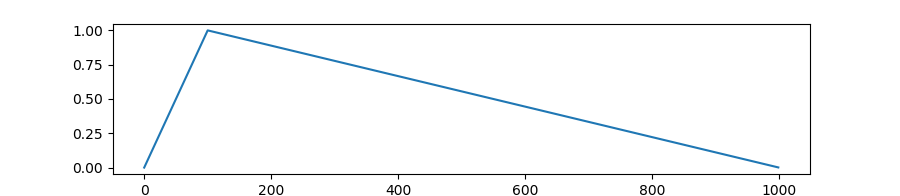

In [ ]:
from IPython.display import Image
Image(filename='/content/warmup_linear_schedule.png')